In [10]:
!pip install pystackreg

     |████████████████████████████████| 3.7 MB 7.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pystackreg: filename=pystackreg-0.2.5-cp37-cp37m-linux_x86_64.whl size=497784 sha256=9b5f1959118d02bbe412233c9c9dc066eb98af7b14a40f8708e3b326a4bf2f22
  Stored in directory: /root/.cache/pip/wheels/6c/da/4c/e2ffadbf7c41f02403b03c496c07d4fd2cbf0862222ade6685
Successfully built pystackreg


In [11]:
#Importation des bibliothèque à utiliser 
#import vtk
#from vtk.util import numpy_support
import os
import numpy as np
from math import *
import matplotlib.pyplot as plt
from matplotlib import cm
from pystackreg import StackReg
from skimage import io
from PIL import Image
from glob import glob
from pathlib import Path, PurePath

# Cartes d'épaisseur sans tenir compte droite/gauche

In [ ]:
#Function to read all the STL files: 
def reading_stl_files(exams):
    readers = [] 
    for i in names: 
        reader = vtk.vtkSTLReader()
        reader.SetFileName('/Final_Data/Tibia/Clean_STL/'+names[i]+'.stl')
        reader.Update() 
        readers.append(reader)

        mapper = vtk.vtkPolyDataMapper()
        mapper.SetInputConnection(reader.GetOutputPort())

        #Create an actor for the mesh 
        actor = vtk.vtkActor()
        actor.SetMapper(mapper)
        ren = vtk.vtkRenderer()
        renWin = vtk.vtkRenderWindow()
        renWin.AddRenderer(ren)

        #Create a renderwindow interactor 
        iren = vtk.vtkRenderWindowInteractor()
        iren.SetRenderWindow(renWin)

        style = vtk.vtkInteractorStyleTrackballCamera()
        iren.SetInteractorStyle(style)


        #Assign actor to the renderer 
        ren.AddActor(actor)


        iren.Initialize()
        renWin.Render()
        iren.Start()

    
    return readers

In [ ]:
#Function to create thickness map of tibial cartilage
def Tibia_Carte(data):
    #Create an oriented bounding box to find the points of intersection
    obbTree = vtk.vtkOBBTree()
    obbTree.SetDataSet(data)
    obbTree.BuildLocator()
    pointsVTKintersection = vtk.vtkPoints()
    l=[]
    l2 = []
    s_x=0
    
    for x in np.arange(data.GetBounds()[0],data.GetBounds()[1]+0.1,0.3):
        s_x+=1
        s_y=0
        for y in np.arange(data.GetBounds()[2],data.GetBounds()[3]+0.1,0.3):
            s_y+=1
            p0 = [x, y, data.GetBounds()[4]]
            p1 = [x, y, data.GetBounds()[5]]
            code = obbTree.IntersectWithLine(p0, p1, pointsVTKintersection, None)

            

            #extract the data 
            pointsVTKIntersectionData = pointsVTKintersection.GetData()
            noPointsVTKIntersection = pointsVTKIntersectionData.GetNumberOfTuples()

            l2.append(noPointsVTKIntersection)
            
            if noPointsVTKIntersection == 0 or noPointsVTKIntersection ==1:
                l.append(0)
            elif noPointsVTKIntersection ==2:
                pointsIntersection = []
                for idx in range(noPointsVTKIntersection):
                    _tup = pointsVTKIntersectionData.GetTuple3(idx)
                    pointsIntersection.append(_tup)
                l.append(sqrt(abs(pointsIntersection[1][2]-pointsIntersection[0][2])**2))
            elif noPointsVTKIntersection > 2:
                pointsIntersection = []
                for idx in range(noPointsVTKIntersection):
                    _tup = pointsVTKIntersectionData.GetTuple3(idx)
                    pointsIntersection.append(_tup)
                s1 = 0
                for i in range(1,noPointsVTKIntersection-1):
                    s1+=sqrt(abs(pointsIntersection[0][2]-pointsIntersection[i+1][2])**2)
                l.append(s1/(noPointsVTKIntersection-1))
        
    return l,s_x,s_y

In [ ]:
#Changing the shape of the image to 300*300 
def reshaping(l2,s_x,s_y):
    s1,s2,s3,s4=0,0,0,0
    if (300-s_x)%2 == 0:
        s1 = (300-s_x)//2
        s2 = (300-s_x)//2
    else:
        s1 = (300-s_x-1)//2
        s2 = (300-s_x-1)//2+1
    if (300-s_y)%2 == 0:
        s3 = (300-s_y)//2
        s4 = (300-s_y)//2
    else:
        s3 = (300-s_y-1)//2
        s4 = (300-s_y-1)//2+1
    
    l3=l2
    l4=np.concatenate((np.zeros((s_x,s3)),l3 ), axis=1)
    l5 =  np.concatenate((l4,np.zeros((s_x,s4)) ), axis=1)
    l6=np.concatenate((np.zeros((s1,300)),l5 ), axis=0)
    l7=np.concatenate((l6,np.zeros((s2,300))), axis=0)
    return l7

In [ ]:
# Connect to Colab
from google.colab import drive
drive.mount('/content/drive/')

# Go to the folder containing the data
%cd /content/drive/MyDrive/Projet_A3S5/Donnees

In [ ]:
#import the metadata file
source_folder = os.path.join('Final_Data','Tibia')
metadata = os.path.join(source_folder,'Metadata.xlsx')
df = pd.read_excel(metadata)
print(df.head())

In [ ]:
# select the data not from Stanford and those which are healthy
df_mask=df['From_Stanford']==0
filtered_df = df[df_mask]
df_mask2=df['Label']==0
filtered_df2 = filtered_df[df_mask2]
print(filtered_df2)

In [ ]:
# extract the names of the files and their orientation
names = filtered_df2['Name'].to_list()
orientation = filtered_df2['Orientation_pca'].to_list()
print(names)
print(orientation)

In [ ]:
readers = reading_stl_files(exams)

In [ ]:
from tqdm import tqdm

#liste of all the tibial cartilage map 
l_listes = []
#liste of shapes of all the tibial cartilage map 
shape_listes=[]
for reader in tqdm(readers):
    l,s_x,s_y = Tibia_Carte(reader.GetOutput())
    l_listes.append(l)
    shape_listes.append((s_x,s_y))

100%|██████████| 24/24 [02:34<00:00,  6.44s/it]


In [ ]:
#Saving tibial catilage map as png and tiff files 
reshaped_listes=[]
for i in range(len(l_listes)):
        l = l_listes[i]
        shape = shape_listes[i]
        l1 = np.array(l)
        l2 = l1.reshape((shape_listes[i][0],shape_listes[i][1]))
        print(l2)
        l_reshaped = reshaping(l2,shape_listes[i][0],shape_listes[i][1])
        reshaped_listes.append(l_reshaped)
        plt.imshow(l_reshaped,cmap='gray')
        plt.colorbar()
        plt.plot()
        im = Image.fromarray(l_reshaped)
        im.save('/Final_Data/Tibia/Map/Original/'+names[i]+'.tiff')
        plt.imsave('/Final_Data/Tibia/Map/Original/'+names[i]+'.png',l_reshaped,cmap="gray")
        plt.clf()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

<Figure size 432x288 with 0 Axes>

# Mirror effect

In [ ]:
#Doing mirror effect to make all the cartilage as right cartilage 
mirror_listes = []
for i in range(len(l_listes)):
    l = l_listes[i]
    shape = shape_listes[i]
    l1 = np.array(l)
    l2 = l1.reshape((shape_listes[i][0],shape_listes[i][1]))
    l_reshaped = reshaping(l2,shape_listes[i][0],shape_listes[i][1])
    if orientation[i]==1:
        mirror_listes.append(l_reshaped)
    else: 
        print(l_reshaped[75][150])
        mirror_listes.append(np.flip(l_reshaped,0))
        print(l_reshaped[75][150])

1.4844970703125
1.4844970703125
1.3525390625
1.3525390625
1.7642822265625
1.7642822265625
1.7642822265625
1.7642822265625
2.1910400390625
2.1910400390625
2.1910400390625
2.1910400390625
3.27166748046875
3.27166748046875
1.34869384765625
1.34869384765625
1.6007080078125
1.6007080078125
1.2791748046875
1.2791748046875


In [ ]:
#Saving mirror images as png and tiff 
for i in range(len(mirror_listes)):
    plt.imshow(mirror_listes[i],cmap='gray')
    plt.colorbar()
    plt.plot()
    plt.imsave('/Final_Data/Tibia/Map/Mirror/'+names[i]+'.png',mirror_listes[i],cmap="gray")
    im = Image.fromarray(mirror_listes[i])
    im.save('/Final_Data/Tibia/Map/Mirror/'+names[i]+'.tiff')
    plt.clf()

<Figure size 432x288 with 0 Axes>

# Découpage en 2

In [ ]:
#list of upper tibial cartilage map 
haut_liste_tiff = []
haut_liste_png=[]
#list of lower cartilage map 
bas_liste_tiff=[]
bas_liste_png=[]
for i in range(len(names)):
    mirror_image = Image.open('/Final_Data/Tibia/Map/Mirror/'+names[i]+'.tiff')
    mirror_image_pixel = Image.open('/Final_Data/Tibia/Map/Mirror/'+names[i]+'.png').convert('L')
    mirror_image_arr = np.asarray(mirror_image)
    mirror_image_arr_pixel = np.asarray(mirror_image_pixel)
    genous_haut = mirror_image_arr[0:150,:]
    genous_haut_png = mirror_image_arr_pixel[0:150,:]
    genous_bas = mirror_image_arr[150:300,:]
    genous_bas_png = mirror_image_arr_pixel[150:300,:]
    haut_liste_tiff.append(genous_haut)
    haut_liste_png.append(genous_haut_png)
    bas_liste_tiff.append(genous_bas)
    bas_liste_png.append(genous_bas_png)

In [ ]:
#Saving upper and lower tibial cartilage as images
for i in range(len(names)):
    genous_haut_image = Image.fromarray(haut_liste_tiff[i])
    genous_bas_image = Image.fromarray(bas_liste_tiff[i])
    genous_haut_image.save('/Final_Data/Tibia/Map/genoux_haut/'+names[i]+'.tiff')
    plt.imsave('/Final_Data/Tibia/Map/genoux_haut/'+names[i]+'.png',haut_liste_png[i],cmap='gray')
    plt.clf
    genous_bas_image.save('/Final_Data/Tibia/Map/genoux_bas/'+names[i]+'.tiff')
    plt.imsave('/Final_Data/Tibia/Map/genoux_bas/'+names[i]+'.png',bas_liste_png[i],cmap='gray')
    plt.clf

# Recalage affine

In [2]:
# Connect to Colab
from google.colab import drive
drive.mount('/content/drive/')

# Go to the folder containing the data
%cd /content/drive/MyDrive/Projet_A3S5/Donnees

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1VyeGE8G8NemjPGnlHQA2fEjmVxwDsQTS/Projet_A3S5/Donnees


In [3]:
# Reaload mirror maps (if previous maps variable have been cleared)
folder_source = 'Final_Data/Tibia/Map'
original_target = os.path.join(folder_source, 'Genoux_haut')
file_paths = [path for path in glob(os.path.join(original_target, '*.tiff'))]
file_names = [PurePath(p).name.split('.')[0] for p in file_paths]
maps_haut = np.array([np.array(Image.open(p)) for p in file_paths])
Nfiles = len(file_paths)
print(f"{Nfiles} maps loaded.")

193 maps loaded.


In [4]:
original_target = os.path.join(folder_source, 'Genoux_bas')
file_paths = [path for path in glob(os.path.join(original_target, '*.tiff'))]
file_names = [PurePath(p).name.split('.')[0] for p in file_paths]
maps_bas = np.array([np.array(Image.open(p)) for p in file_paths])
Nfiles = len(file_paths)
print(f"{Nfiles} maps loaded.")

193 maps loaded.


In [7]:
#reference image of upper tibial cartilage for registration 
ref_image_haut = Image.open("Final_Data/Tibia/Map/Genoux_haut/Tibia_59.png").convert("L")
ref_arr_haut = np.asarray(ref_image_haut)
ref_image_haut_tiff = Image.open("Final_Data/Tibia/Map/Genoux_haut/Tibia_59.tiff")
ref_arr_haut_tiff = np.asarray(ref_image_haut_tiff)
#reference image of lower tibial cartilage for registration 
ref_image_bas = Image.open("Final_Data/Tibia/Map/Genoux_bas/Tibia_59.png").convert("L")
ref_arr_bas = np.asarray(ref_image_bas)
ref_image_bas_tiff = Image.open("Final_Data/Tibia/Map/Genoux_bas/Tibia_59.tiff")
ref_arr_bas_tiff = np.asarray(ref_image_bas_tiff)

In [16]:
# Save map as png and tiff
def save_map(im, folder, name):
    path = os.path.join(folder, name)
    Image.fromarray(im).save(path + ".tiff")
    plt.imsave(path + ".png", im, cmap='gray')

In [18]:
from tqdm import tqdm

# Target folders
folder_source = "Final_Data/Tibia/Map/Genoux_haut"
affine_path = os.path.join(folder_source, "Affine")
rigid_path = os.path.join(folder_source, "Rigid")
Path(affine_path).mkdir(parents=True, exist_ok=True)
Path(rigid_path).mkdir(parents=True, exist_ok=True)

# Readjusments
affine_maps = []
rigid_maps = []

# Map of reference
ref_image = maps_haut.mean(axis=0)

pbar = tqdm(zip(maps_haut, file_names), desc='Maps', leave=True, total=Nfiles)
for im, name in pbar:
    # Readjusments
    aff = StackReg(StackReg.AFFINE).register_transform(ref_image, im)
    affine_maps.append(aff)
    rig = StackReg(StackReg.RIGID_BODY).register_transform(ref_image, im)
    rigid_maps.append(rig)

    # Save readjusted maps
    save_map(aff, affine_path, name)
    save_map(rig, rigid_path, name)

affine_maps = np.array(affine_maps)
rigid_maps = np.array(rigid_maps)

Maps: 100%|██████████| 193/193 [00:31<00:00,  6.10it/s]


In [19]:
from tqdm import tqdm

# Target folders
folder_source = "Final_Data/Tibia/Map/Genoux_bas"
affine_path = os.path.join(folder_source, "Affine")
rigid_path = os.path.join(folder_source, "Rigid")
Path(affine_path).mkdir(parents=True, exist_ok=True)
Path(rigid_path).mkdir(parents=True, exist_ok=True)

# Readjusments
affine_maps = []
rigid_maps = []

# Map of reference
ref_image = maps_bas.mean(axis=0)

pbar = tqdm(zip(maps_bas, file_names), desc='Maps', leave=True, total=Nfiles)
for im, name in pbar:
    # Readjusments
    aff = StackReg(StackReg.AFFINE).register_transform(ref_image, im)
    affine_maps.append(aff)
    rig = StackReg(StackReg.RIGID_BODY).register_transform(ref_image, im)
    rigid_maps.append(rig)

    # Save readjusted maps
    save_map(aff, affine_path, name)
    save_map(rig, rigid_path, name)

affine_maps = np.array(affine_maps)
rigid_maps = np.array(rigid_maps)

Maps: 100%|██████████| 193/193 [00:31<00:00,  6.18it/s]


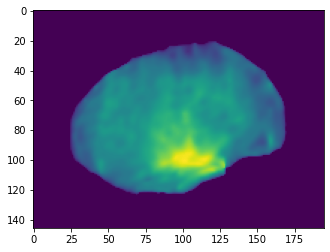

In [12]:
#plotting reference image  of superior tibial cartilage 
plt.imshow(ref_arr_haut)
plt.plot()
#list of affine registration arrays for upper tibial cartilage
aff_haut=[]
#Doing affine registration of supperior  tibial cartilage 
for i in range(len(file_names)):
    genous_haut_image_png = Image.fromarray(maps_haut[i]).convert("L")
    arr = np.asarray(genous_haut_image_png)
    sr = StackReg(StackReg.AFFINE)
    out = sr.register_transform(ref_arr_haut,arr)
    aff_haut.append(out)

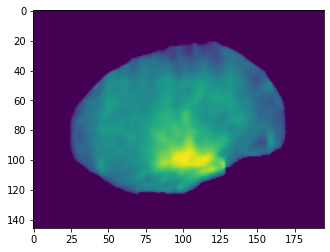

In [13]:
plt.imshow(ref_arr_haut_tiff)
plt.plot()
aff_haut_tiff=[]
for i in range(len(file_names)):
    genous_haut_image_tiff = Image.fromarray(maps_haut[i])
    arr = np.asarray(genous_haut_image_tiff)
    sr = StackReg(StackReg.AFFINE)
    out = sr.register_transform(ref_arr_haut_tiff,arr)
    aff_haut_tiff.append(out)

IndexError: ignored

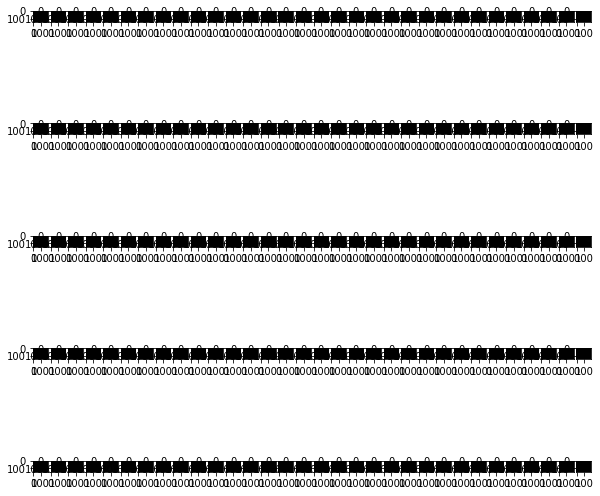

In [15]:
fig, axs = plt.subplots(5,int(len(file_names)/6),figsize = (10,10))

#plotting superior tibial Cartilage after an affine registration 
axs = axs.ravel()
for i in range(len(file_names)):
    axs[i].imshow(aff_haut[i], cmap='gray',vmin =0,vmax = 255)
    #saving each image after affine registration 
    plt.imsave('Final_Data/Tibia/Map/Genoux_haut/Affine/'+file_names[i]+'.png',aff_haut[i],cmap = cm.gray)

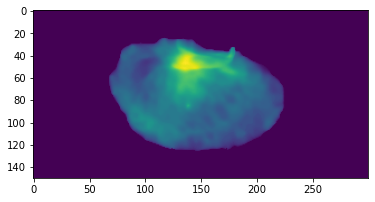

In [ ]:
#plotting reference image 
plt.imshow(ref_arr_bas)
plt.plot()
#list of affine registration arrays for upper tibial cartilage
aff_bas=[]
#list of affine registration arrays for lower tibial cartilage 
for i in range(len(names)):
    genous_bas_image_png = Image.fromarray(bas_liste_png[i]).convert("L")
    arr = np.asarray(genous_bas_image_png)
    sr = StackReg(StackReg.AFFINE)
    out = sr.register_transform(ref_arr_bas,arr)
    aff_bas.append(out)

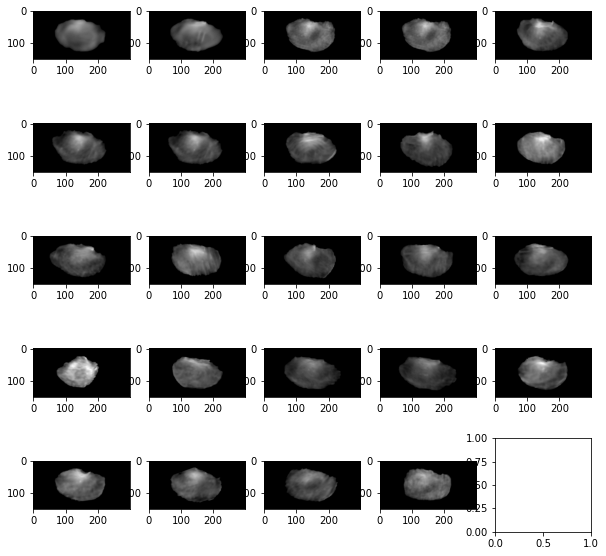

In [ ]:
fig, axs = plt.subplots(5,int(len(names)/6),figsize = (10,10))
#fig.subplots_adjust(hspace = .5, wspace=.001)
#plotting lower cartilage after affine registration 
axs = axs.ravel()
for i in range(len(names)):
    axs[i].imshow(aff_bas[i], cmap='gray',vmin =0,vmax = 255)
    #saving each images after affine registration
    plt.imsave('/Final_Data/Tibia/Map/Genoux_bas/Affine/'+names[i]+'.png',aff_bas[i],cmap = cm.gray)

# Recalage rigide

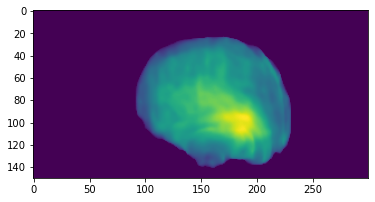

In [ ]:
#plotting reference image 
plt.imshow(ref_arr_haut)
plt.plot()
#list of rigid registration arrays for upper tibial cartilage
rigide_haut=[]
#list of rigid registration arrays for lower tibial cartilage 
for i in range(len(names)):
    genous_haut_image_png = Image.fromarray(haut_liste_png[i]).convert("L")
    arr = np.asarray(genous_haut_image_png)
    sr = StackReg(StackReg.RIGID_BODY)
    out_rigid = sr.register_transform(ref_arr_haut,arr)
    rigide_haut.append(out_rigid)

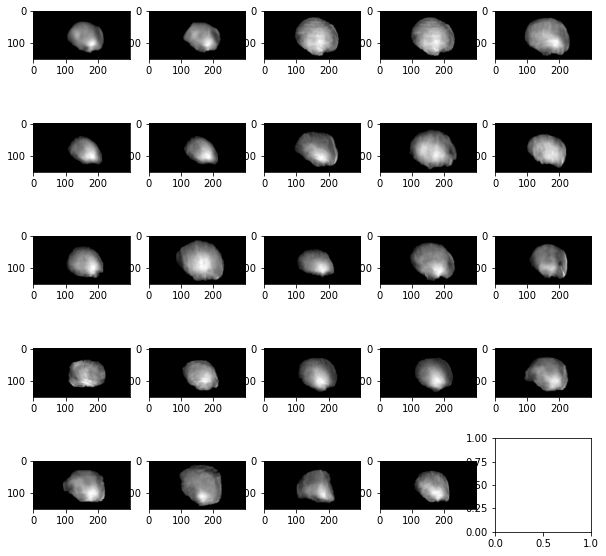

In [ ]:
fig, axs = plt.subplots(5,int(len(names)/6),figsize = (10,10))
#fig.subplots_adjust(hspace = .5, wspace=.001)
#plotting superior tibial cartilage after rigid registration 
axs = axs.ravel()
for i in range(len(names)):
    axs[i].imshow(rigide_haut[i], cmap='gray',vmin =0,vmax = 255)
    #saving images after rigid registration 
    plt.imsave('/Final_Data/Tibia/Map/Genaux_haut/Rigid/'+names[i]+'.png',rigide_haut[i],cmap = cm.gray)

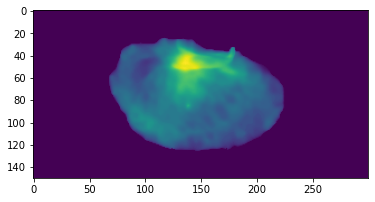

In [ ]:
#plotting reference image 
plt.imshow(ref_arr_bas)
plt.plot()
#list of rigid registration arrays for upper tibial cartilage
rigide_bas=[]
#Doing rigid registration 
for i in range(len(names)):
    genous_bas_image_png = Image.fromarray(bas_liste_png[i]).convert("L")
    arr = np.asarray(genous_bas_image_png)
    sr = StackReg(StackReg.RIGID_BODY)
    out_rigid = sr.register_transform(ref_arr_bas,arr)
    rigide_bas.append(out_rigid)

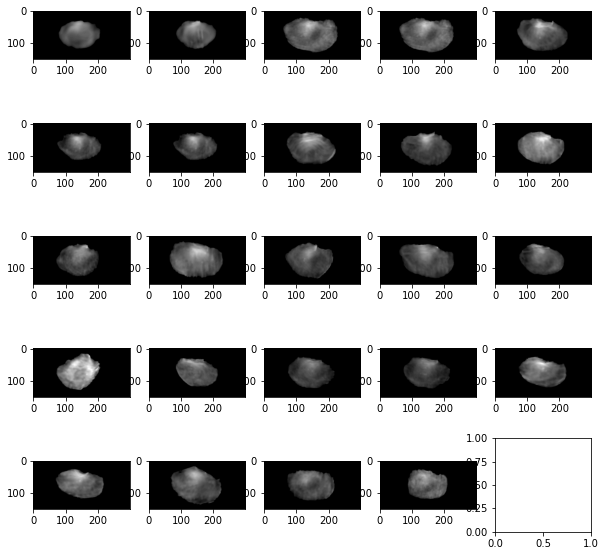

In [ ]:
fig, axs = plt.subplots(5,int(len(names)/6),figsize = (10,10))
#fig.subplots_adjust(hspace = .5, wspace=.001)
#Plotting and saving lower cartilage after rigid registration 
axs = axs.ravel()
for i in range(len(names)):
    axs[i].imshow(rigide_bas[i], cmap='gray',vmin =0,vmax = 255)
    plt.imsave('/Final_Data/Tibia/Map/Genoux_bas/Rigid/'+names[i]+'.png',rigide_bas[i],cmap = cm.gray)

# Calculer les moyennes

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

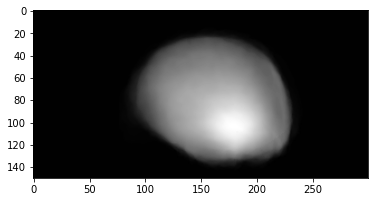

In [ ]:
#Create average images after affine registration of superior tibial cartilage
image_moyenne_affine_haut = np.zeros((150,300))
for i in range(len(names)):
    im = Image.open('/Final_Data/Tibia/Map/Genoux_haut/Affine/'+names[i]+'.png').convert("L")
    im_arr = np.asarray(im)
    image_moyenne_affine_haut+=im_arr
image_moyenne_affine_haut//=len(names)
#Plotting average images 
plt.imshow(image_moyenne_affine_haut,cmap="gray")
plt.imsave('/Final_Data/Tibia/Map/Genoux_haut/Affine/image_moyenne_haut_sain.png',image_moyenne_affine_haut,cmap="gray")
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

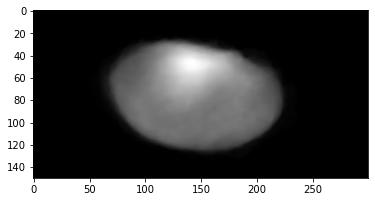

In [ ]:
#Creating average image of lower tibial cartilage after affine registration 
image_moyenne_affine_bas = np.zeros((150,300))
for i in range(len(names)):
    im = Image.open('/Final_Data/Tibia/Map/Genoux_bas/Affine/'+names[i]+'.png').convert("L")
    im_arr = np.asarray(im)
    image_moyenne_affine_bas+=im_arr
image_moyenne_affine_bas//=len(names)
#Plotting the average image
plt.imshow(image_moyenne_affine_bas,cmap="gray")
plt.imsave("/Final_Data/Tibia/Map/Genoux_bas/Affine/image_moyenne_bas_sain.png",image_moyenne_affine_bas,cmap="gray")
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

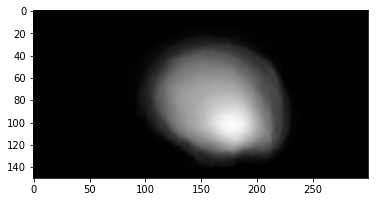

In [ ]:
#Create average image of tibial Cartilage after rigid registration 
image_moyenne_rigide_haut = np.zeros((150,300))
for i in range(len(names)):
    im = Image.open('/Final_Data/Tibia/Map/Genoux_haut/Rigid/'+names[i]+'.png').convert("L")
    im_arr = np.asarray(im)
    image_moyenne_rigide_haut+=im_arr
image_moyenne_rigide_haut//=len(names)
plt.imshow(image_moyenne_rigide_haut,cmap="gray")
#plotting the average images 
plt.imsave('/Final_Data/Tibia/Map/Genoux_haut/Rigid/image_moyenne_haut_sain.png',image_moyenne_rigide_haut,cmap="gray")
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

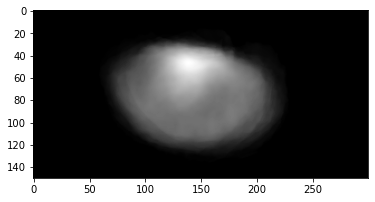

In [ ]:
#Creating average image of lower tibial cartilage after rigid registration 
image_moyenne_rigide_bas = np.zeros((150,300))
for i in range(len(names)):
    im = Image.open('/Final_Data/Tibia/Map/Genoux_bas/Rigid/'+names[i]+'.png').convert("L")
    im_arr = np.asarray(im)
    image_moyenne_rigide_bas+=im_arr
image_moyenne_rigide_bas//=len(names)
plt.imshow(image_moyenne_rigide_bas,cmap="gray")
plt.imsave('/Final_Data/Tibia/Map/Genoux_bas/Rigid/image_moyenne_bas_sain.png',image_moyenne_rigide_bas,cmap="gray")
plt.plot

# Max

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

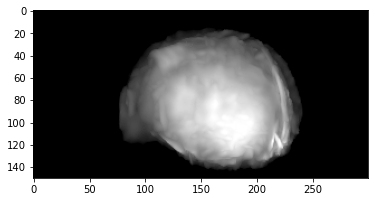

In [ ]:
#Create max images after affine registration of superior tibial cartilage
image_max_affine_haut = Image.open('/Final_Data/Tibia/Map/Genoux_haut/Affine/'+names[0]+'.png') .convert("L")
image_max_affine_haut_arr = np.asarray(image_max_affine_haut)
image_max_affine_haut_array = np.copy(image_max_affine_haut_arr)
for i in range(1,len(names)):
    im = Image.open('/Final_Data/Tibia/Map/Genoux_haut/Affine/'+names[i]+'.png'v).convert("L")
    im_arr = np.asarray(im)
    for j in range(150):
        for k in range(300):
            if im_arr[j][k]>image_max_affine_haut_array[j][k]:
                image_max_affine_haut_array[j][k] = im_arr[j][k]
#Plotting average images 
plt.imshow(image_max_affine_haut_array,cmap="gray")
plt.imsave('/Final_Data/Tibia/Map/Genoux_haut/Affine/image_max_haut_sain.png',image_max_affine_haut_array,cmap="gray")
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

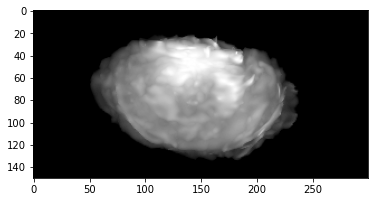

In [ ]:
#Create max images after affine registration of inferior tibial cartilage
image_max_affine_haut = Image.open('/Final_Data/Tibia/Map/Genoux_bas/Affine/'+names[0]+'.png') .convert("L")
image_max_affine_haut_arr = np.asarray(image_max_affine_haut)
image_max_affine_haut_array = np.copy(image_max_affine_haut_arr)
for i in range(1,len(names)):
    im = Image.open('/Final_Data/Tibia/Map/Genoux_bas/Affine/'+names[i]+'.png').convert("L")
    im_arr = np.asarray(im)
    for j in range(150):
        for k in range(300):
            if im_arr[j][k]>image_max_affine_haut_array[j][k]:
                image_max_affine_haut_array[j][k] = im_arr[j][k]
#Plotting average images 
plt.imshow(image_max_affine_haut_array,cmap="gray")
plt.imsave('/Final_Data/Tibia/Map/Genoux_bas/Affine/image_max_bas_sain.png',image_max_affine_haut_array,cmap="gray")
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

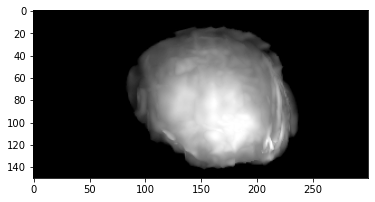

In [ ]:
#Create max images after rigid registration of superior tibial cartilage
image_max_affine_haut = Image.open('/Final_Data/Tibia/Map/Genoux_haut/Rigid/'+names[0]+'.png') .convert("L")
image_max_affine_haut_arr = np.asarray(image_max_affine_haut)
image_max_affine_haut_array = np.copy(image_max_affine_haut_arr)
for i in range(1,len(names)):
    im = Image.open('/Final_Data/Tibia/Map/Genoux_haut/Rigid/'+names[i]+'.png').convert("L")
    im_arr = np.asarray(im)
    for j in range(150):
        for k in range(300):
            if im_arr[j][k]>image_max_affine_haut_array[j][k]:
                image_max_affine_haut_array[j][k] = im_arr[j][k]
#Plotting average images 
plt.imshow(image_max_affine_haut_array,cmap="gray")
plt.imsave('/Final_Data/Tibia/Map/Genoux_haut/Rigid/image_max_haut_sain.png',image_max_affine_haut_array,cmap="gray")
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

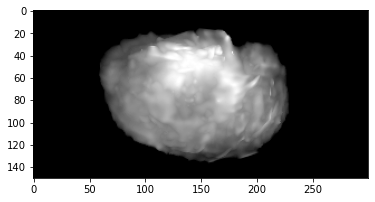

In [ ]:
#Create max images after rigid registration of inferior tibial cartilage
image_max_affine_haut = Image.open('/Final_Data/Tibia/Map/Genoux_bas/Rigid/'+names[0]+'.png') .convert("L")
image_max_affine_haut_arr = np.asarray(image_max_affine_haut)
image_max_affine_haut_array = np.copy(image_max_affine_haut_arr)
for i in range(1,len(names)):
    im = Image.open('/Final_Data/Tibia/Map/Genoux_bas/Rigid/'+names[i]+'.png').convert("L")
    im_arr = np.asarray(im)
    for j in range(150):
        for k in range(300):
            if im_arr[j][k]>image_max_affine_haut_array[j][k]:
                image_max_affine_haut_array[j][k] = im_arr[j][k]
#Plotting average images 
plt.imshow(image_max_affine_haut_array,cmap="gray")
plt.imsave('/Final_Data/Tibia/Map/Genoux_bas/Rigid/image_max_bas_sain.png',image_max_affine_haut_array,cmap="gray")
plt.plot

# Min

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

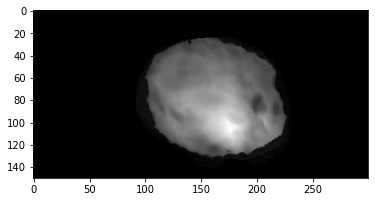

In [ ]:
#Create min images after affine registration of superior tibial cartilage
image_min_affine_haut = Image.open('/Final_Data/Tibia/Map/Genoux_haut/Affine/'+names[0]+'.png') .convert("L")
image_min_affine_haut_arr = np.asarray(image_min_affine_haut)
image_min_affine_haut_array = np.copy(image_min_affine_haut_arr)
for i in range(1,len(names)):
    im = Image.open('/Final_Data/Tibia/Map/Genoux_haut/Affine/'+names[i]+'.png').convert("L")
    im_arr = np.asarray(im)
    for j in range(150):
        for k in range(300):
            if im_arr[j][k]<image_min_affine_haut_array[j][k]:
                image_min_affine_haut_array[j][k] = im_arr[j][k]
#Plotting average images 
plt.imshow(image_min_affine_haut_array,cmap="gray")
plt.imsave('/Final_Data/Tibia/Map/Genoux_haut/Affine/image_min_haut_sain.png',image_min_affine_haut_array,cmap="gray")
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

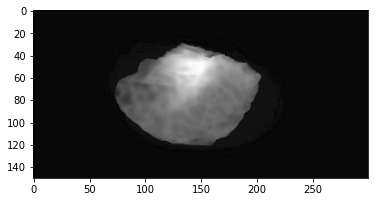

In [ ]:
#Create min images after affine registration of inferior tibial cartilage
image_min_affine_haut = Image.open('/Final_Data/Tibia/Map/Genoux_bas/Affine/'+names[0]+'.png') .convert("L")
image_min_affine_haut_arr = np.asarray(image_min_affine_haut)
image_min_affine_haut_array = np.copy(image_min_affine_haut_arr)
for i in range(1,len(names)):
    im = Image.open'/Final_Data/Tibia/Map/Genoux_bas/Affine/'+names[i]+'.png').convert("L")
    im_arr = np.asarray(im)
    for j in range(150):
        for k in range(300):
            if im_arr[j][k]<image_min_affine_haut_array[j][k]:
                image_min_affine_haut_array[j][k] = im_arr[j][k]
#Plotting average images 
plt.imshow(image_min_affine_haut_array,cmap="gray")
plt.imsave('/Final_Data/Tibia/Map/Genoux_bas/Affine/image_min_bas_sain.png',image_min_affine_haut_array,cmap="gray")
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

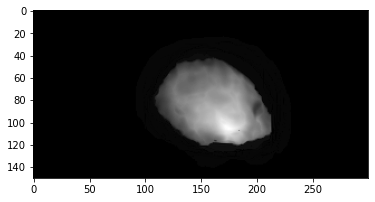

In [ ]:
#Create min images after rigid registration of superior tibial cartilage
image_min_affine_haut = Image.open('/Final_Data/Tibia/Map/Genoux_haut/Rigid/'+names[0]+'.png') .convert("L")
image_min_affine_haut_arr = np.asarray(image_min_affine_haut)
image_min_affine_haut_array = np.copy(image_min_affine_haut_arr)
for i in range(1,len(names)):
    im = Image.open('/Final_Data/Tibia/Map/Genoux_haut/Rigid/'+names[i]+'.png').convert("L")
    im_arr = np.asarray(im)
    for j in range(150):
        for k in range(300):
            if im_arr[j][k]<image_min_affine_haut_array[j][k]:
                image_min_affine_haut_array[j][k] = im_arr[j][k]
#Plotting average images 
plt.imshow(image_min_affine_haut_array,cmap="gray")
plt.imsave('/Final_Data/Tibia/Map/Genoux_haut/Rigid/rigide_min_haut_sain.png',image_min_affine_haut_array,cmap="gray")
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

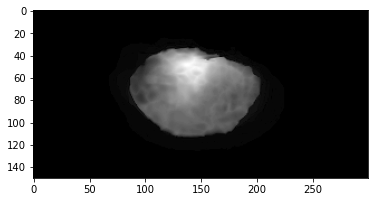

In [ ]:
#Create min images after rigid registration of inferior tibial cartilage
image_min_affine_haut = Image.open('/Final_Data/Tibia/Map/Genoux_bas/Rigid/'+names[0]+'.png') .convert("L")
image_min_affine_haut_arr = np.asarray(image_min_affine_haut)
image_min_affine_haut_array = np.copy(image_min_affine_haut_arr)
for i in range(1,len(names)):
    im = Image.open('/Final_Data/Tibia/Map/Genoux_bas/Rigid/'+names[i]+'.png').convert("L")
    im_arr = np.asarray(im)
    for j in range(150):
        for k in range(300):
            if im_arr[j][k]<image_min_affine_haut_array[j][k]:
                image_min_affine_haut_array[j][k] = im_arr[j][k]
#Plotting average images 
plt.imshow(image_min_affine_haut_array,cmap="gray")
plt.imsave('/Final_Data/Tibia/Map/Genoux_bas/Rigid/image_min_bas_sain.png',image_min_affine_haut_array,cmap="gray")
plt.plot